# FBA QUANT AP HW7
Kim Soo Wan(hse07088@snu.ac.kr)
***

In [371]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# **Data Description**

### Table1. Market.csv
- mdate: Monthly reference date (last day of the month)
- market: Monthly return of market portfolio
- risk_free: Monthly return of risk-free asset

### Table2. Header.csv
- cusip: CUSIP (Committee on Uniform Securities Identification Procedures) number
- Ticker: Ticker symbol
- Ticker_alt: Alternative ticker symbol
- Legal: Company name
- delist_date: Delisting date
- GICS_code: Industry classification code

### Table3. Value.csv
- cusip: CUSIP number
- mdate: Monthly reference date (last day of the month)
- open: Monthly opening price of the security
- close: Monthly adjusted closing price of the security
- return: Monthly return of the security (considering dividend yield, stock splits, etc.)
- cap: Monthly average market capitalization of the security
- volume: Monthly average trading volume of the security
- beta: Beta of the security
- short_cost: Short selling cost of the security
- PBR: Market capitalization / book value of equity
- PER: Market capitalization / net income
- PSR: Market capitalization / total sales
- DIVY: Dividend payout ratio (dividend paid / earnings available for dividend)

### Table4. Size.csv
- Same as Table3.Value.csv
- Size: Size factor score
- Quality: Quality factor score (added for the Size matters, If you control your Junk implementation in the additional task)


### **Problem 1. Value and Size – Long Portfolio**
Verify that the Value and Size portfolios show high risk-adjusted returns compared to the market.

1. Data Load
    Load the Value.csv and Size.csv files as pandas DataFrames.

    Load the Market.csv file as a pandas DataFrame.

2. Z-Scoring
    The data provided is already Z-Scored. Use 0 to fill in missing values.

3. Score Aggregation
    Calculate the combined score using the following formulas:

    Value Factor = PBR + PSR + PER - DIVY

    Size Factor = Size

    (Note that for DIVY, use a negative value to include stocks with high dividend payout ratios when purchasing the bottom 30%.)

4. Construct Long Portfolio
    Use the following criteria to construct the Long Portfolio:

    Value Factor: Buy the bottom 30% (value stocks) based on the combined score.

    Size Factor: Buy the bottom 30% (small-cap stocks) based on the combined score.

    Use market capitalization weighting to determine the weight of each stock in the portfolio. The holding period is 18 months, and at the end of the holding period, the portfolio is reconstructed using the bottom 30% of stocks based on the combined Z-Score. (rebalancing)

5. Comparison to Benchmark
    Compare the cumulative returns, risk-adjusted returns (Sharpe Ratio, Information Ratio), and MDD between the High Value portfolio and the market portfolio.

    Compare the cumulative returns, risk-adjusted returns, and MDD between the Small Size portfolio and the market portfolio.

6. Visualization
    Visualize the cumulative returns, MDD, and other metrics.

In [372]:
header_raw = pd.read_csv('data/Header.csv')
mkt_raw = pd.read_csv('data/Market.csv')
size_raw = pd.read_csv('data/Size_Factor.csv')
value_raw = pd.read_csv('data/Value_Factor.csv')

In [373]:
header_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30226 entries, 0 to 30225
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   cusip        30226 non-null  object 
 1   Ticker       30225 non-null  object 
 2   Ticker_alt   30090 non-null  object 
 3   Legal        30226 non-null  object 
 4   delist_date  19665 non-null  object 
 5   GICS_code    21856 non-null  float64
dtypes: float64(1), object(5)
memory usage: 1.4+ MB


In [374]:
mkt_raw.info()
mkt_raw

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627 entries, 0 to 626
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   mdate      627 non-null    object 
 1   market     627 non-null    float64
 2   risk_free  627 non-null    float64
dtypes: float64(2), object(1)
memory usage: 14.8+ KB


,mdate,market,risk_free
0,1970-01-31,-0.073254,0.0060
1,1970-02-28,0.056706,0.0062
2,1970-03-31,-0.004729,0.0057
3,1970-04-30,-0.105318,0.0050
4,1970-05-31,-0.064346,0.0053
...,...,...,...
622,2021-11-30,-0.018350,0.0000
623,2021-12-31,0.033341,0.0001
624,2022-01-31,-0.059822,0.0000
625,2022-02-28,-0.021838,0.0000


In [375]:
print(size_raw.isna().sum())
size_raw

cusip              0
mdate              0
open           59569
close          66227
return         66259
cap            66227
volume        249706
beta           45419
short_cost     34252
Size           59569
Quality       685843
dtype: int64


,cusip,mdate,open,close,return,cap,volume,beta,short_cost,Size,Quality
0,000957100,1970-01-31,34.875,37.750,0.082437,46734.0,1.090000e+04,0.721091,-0.0092,-0.171009,NaN
1,001007103,1970-01-31,25.250,28.000,0.112943,147560.0,1.068000e+05,-0.484350,-0.0038,-0.103811,NaN
2,001412105,1970-01-31,4.500,4.000,-0.111111,13100.0,5.520000e+04,2.088036,-0.0340,-0.192267,NaN
3,001476100,1970-01-31,9.875,9.375,-0.050633,38550.0,1.253000e+05,1.165014,-0.0092,-0.172930,NaN
4,001688100,1970-01-31,17.625,21.000,0.205787,375081.0,2.460000e+05,1.917081,-0.0037,0.032041,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2643446,98986M103,2021-12-31,9.970,7.920,-0.117637,346199.0,6.318261e+06,0.283821,-0.0092,-0.148215,-0.030336
2643447,98986T108,2021-12-31,6.400,9.070,0.417188,10270941.0,1.232632e+09,0.442438,-0.0037,-0.064646,0.385530
2643448,98986X109,2021-12-31,2.880,2.610,-0.093750,107579.0,1.538238e+07,5.036167,-0.0340,-0.151585,-0.120180
2643449,G65163100,2021-12-31,7.300,4.150,-0.431507,2506160.0,9.260847e+07,0.331590,-0.0037,-0.099497,NaN


In [376]:
print(value_raw.isna().sum())
value_raw

cusip               0
mdate               0
open            59569
close           66227
return          66259
cap             66227
volume         249706
beta            45419
short_cost      34252
PBR            136326
PSR            101674
PER            277981
DIVY          1625376
dtype: int64


,cusip,mdate,open,close,return,cap,volume,beta,short_cost,PBR,PSR,PER,DIVY
0,000957100,1970-01-31,34.875,37.750,0.082437,46734.0,1.090000e+04,0.721091,-0.0092,0.449575,-0.312875,0.532018,-1.536913
1,001007103,1970-01-31,25.250,28.000,0.112943,147560.0,1.068000e+05,-0.484350,-0.0038,-0.214516,0.083993,0.136582,-1.079109
2,001412105,1970-01-31,4.500,4.000,-0.111111,13100.0,5.520000e+04,2.088036,-0.0340,NaN,-0.321920,-0.332169,NaN
3,001476100,1970-01-31,9.875,9.375,-0.050633,38550.0,1.253000e+05,1.165014,-0.0092,-0.266157,-0.384673,-0.125274,NaN
4,001688100,1970-01-31,17.625,21.000,0.205787,375081.0,2.460000e+05,1.917081,-0.0037,-0.282932,-0.389761,-0.370839,0.732604
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2643446,98986M103,2021-12-31,9.970,7.920,-0.117637,346199.0,6.318261e+06,0.283821,-0.0092,0.113432,-0.164093,0.312478,NaN
2643447,98986T108,2021-12-31,6.400,9.070,0.417188,10270941.0,1.232632e+09,0.442438,-0.0037,-0.304368,-0.168530,-1.097550,NaN
2643448,98986X109,2021-12-31,2.880,2.610,-0.093750,107579.0,1.538238e+07,5.036167,-0.0340,-0.391849,NaN,-0.127797,NaN
2643449,G65163100,2021-12-31,7.300,4.150,-0.431507,2506160.0,9.260847e+07,0.331590,-0.0037,-0.192592,NaN,NaN,NaN


In [377]:
value = value_raw
size = size_raw
mkt = mkt_raw
value['mdate'] = pd.to_datetime(value['mdate']).dt.to_period(freq='M')
size['mdate'] = pd.to_datetime(size['mdate']).dt.to_period(freq='M')
mkt['mdate'] = pd.to_datetime(mkt['mdate']).dt.to_period(freq='M')
mkt.set_index('mdate')

,market,risk_free
mdate,,
1970-01,-0.073254,0.0060
1970-02,0.056706,0.0062
1970-03,-0.004729,0.0057
1970-04,-0.105318,0.0050
1970-05,-0.064346,0.0053
...,...,...
2021-11,-0.018350,0.0000
2021-12,0.033341,0.0001
2022-01,-0.059822,0.0000


In [378]:
# scoring
value['total_score'] = value[['PBR', 'PSR', 'PER']].fillna(0).sum(axis=1)-value['DIVY'].fillna(0)
size['total_score'] = size['Size'].fillna(0)
print(value[['mdate', 'cusip', 'total_score']])
print(size[['mdate', 'cusip', 'total_score']])

           mdate      cusip  total_score
0        1970-01  000957100     2.205631
1        1970-01  001007103     1.085168
2        1970-01  001412105    -0.654089
3        1970-01  001476100    -0.776104
4        1970-01  001688100    -1.776136
...          ...        ...          ...
2643446  2021-12  98986M103     0.261817
2643447  2021-12  98986T108    -1.570448
2643448  2021-12  98986X109    -0.519645
2643449  2021-12  G65163100    -0.192592
2643450  2021-12  G8588X103    -0.416676

[2643451 rows x 3 columns]
           mdate      cusip  total_score
0        1970-01  000957100    -0.171009
1        1970-01  001007103    -0.103811
2        1970-01  001412105    -0.192267
3        1970-01  001476100    -0.172930
4        1970-01  001688100     0.032041
...          ...        ...          ...
2643446  2021-12  98986M103    -0.148215
2643447  2021-12  98986T108    -0.064646
2643448  2021-12  98986X109    -0.151585
2643449  2021-12  G65163100    -0.099497
2643450  2021-12  G8588X103  

In [379]:
# constructing long protfolio
value_long_selected = value.groupby('mdate')['total_score'].apply(lambda x: x<x.quantile(0.3))
value_long_port = value[['mdate', 'cusip', 'cap']]
value_long_port.loc[~value_long_selected, 'cap'] = 0
value_long_port['weight'] = value_long_port.groupby('mdate')['cap'].apply(lambda x:x/x.sum())
size_long_selected = size.groupby('mdate')['total_score'].apply(lambda x: x<x.quantile(0.3))
size_long_port = size[['mdate', 'cusip', 'cap']]
size_long_port.loc[~size_long_selected, 'cap'] = 0
size_long_port['weight'] = size_long_port.groupby('mdate')['cap'].apply(lambda x:x/x.sum())
print(value_long_port)
print(size_long_port)

<ipython-input-379-bae9aca55783>:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  value_long_selected = value.groupby('mdate')['total_score'].apply(lambda x: x<x.quantile(0.3))
<ipython-input-379-bae9aca55783>:5: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  value_long_port['weight'] = value_lon

           mdate      cusip         cap    weight
0        1970-01  000957100         0.0  0.000000
1        1970-01  001007103         0.0  0.000000
2        1970-01  001412105         0.0  0.000000
3        1970-01  001476100         0.0  0.000000
4        1970-01  001688100    375081.0  0.002522
...          ...        ...         ...       ...
2643446  2021-12  98986M103         0.0  0.000000
2643447  2021-12  98986T108  10270941.0  0.001908
2643448  2021-12  98986X109         0.0  0.000000
2643449  2021-12  G65163100         0.0  0.000000
2643450  2021-12  G8588X103         0.0  0.000000

[2643451 rows x 4 columns]
           mdate      cusip       cap    weight
0        1970-01  000957100       0.0  0.000000
1        1970-01  001007103       0.0  0.000000
2        1970-01  001412105   13100.0  0.002211
3        1970-01  001476100       0.0  0.000000
4        1970-01  001688100       0.0  0.000000
...          ...        ...       ...       ...
2643446  2021-12  98986M103       0.

<ipython-input-379-bae9aca55783>:9: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  size_long_port['weight'] = size_long_port.groupby('mdate')['cap'].apply(lambda x:x/x.sum())
<ipython-input-379-bae9aca55783>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  size_long_port['weight'] = size_long_port.groupby('mdate')['cap'].apply(lambda x:x/x.sum())


In [380]:
# rebalancing
def rebalance(month_portfolio, rebalance_interval):
    rebalance_interval = pd.DateOffset(months=rebalance_interval)
    last_portfolio = None
    rebalanced_date = None
    rebalanced_portfolio = []
    for month, portfolio in month_portfolio.groupby('mdate'):
        if(not rebalanced_date or pd.Period(rebalanced_date+rebalance_interval, freq='M')<=month):
            rebalanced_date = month.start_time
            last_portfolio = portfolio
        last_portfolio.index=[month]*last_portfolio.shape[0]
        rebalanced_portfolio.append(last_portfolio[['cusip', 'weight']])
    rebalanced_portfolio = pd.concat(rebalanced_portfolio).rename_axis('mdate').set_index('cusip',append=True)
    return rebalanced_portfolio

value_long_port_rebalanced = rebalance(value_long_port, 18)
size_long_port_rebalanced = rebalance(size_long_port, 18)
print(value_long_port_rebalanced)
print(size_long_port_rebalanced)

                     weight
mdate   cusip              
1970-01 000957100  0.000000
        001007103  0.000000
        001412105  0.000000
        001476100  0.000000
        001688100  0.002522
...                     ...
2021-12 98986T108  0.001889
        98986X109  0.000000
        G2124G112  0.000000
        G6S34K105  0.000000
        G8588X103  0.000000

[2616504 rows x 1 columns]
                     weight
mdate   cusip              
1970-01 000957100  0.000000
        001007103  0.000000
        001412105  0.002211
        001476100  0.000000
        001688100  0.000000
...                     ...
2021-12 98986T108  0.000000
        98986X109  0.000860
        G2124G112  0.000293
        G6S34K105  0.000209
        G8588X103  0.000000

[2616504 rows x 1 columns]


In [381]:
value_long_port_rebalanced['weight']

mdate    cusip    
1970-01  000957100    0.000000
         001007103    0.000000
         001412105    0.000000
         001476100    0.000000
         001688100    0.002522
                        ...   
2021-12  98986T108    0.001889
         98986X109    0.000000
         G2124G112    0.000000
         G6S34K105    0.000000
         G8588X103    0.000000
Name: weight, Length: 2616504, dtype: float64

In [382]:
def get_portfolio_returns(custom_rebalanced_portfolio, equipty_results):
    port_monthly_return = pd.DataFrame(custom_rebalanced_portfolio['weight'].multiply(equipty_results['return'].fillna(0), axis='index'))
    port_monthly_return = port_monthly_return.loc[port_monthly_return.index.isin(custom_rebalanced_portfolio.index), :]
    delisting_fillup = port_monthly_return.groupby(level=1).apply(lambda x: x.isna().idxmin())
    port_monthly_return.loc[delisting_fillup[0].values,:] = port_monthly_return.loc[delisting_fillup[0].values,:].apply(lambda x : (~x.isna())*x.fillna(0)+x.isna()*(-custom_rebalanced_portfolio.loc[delisting_fillup[0].values,'weight']))
    port_monthly_return.fillna(0, inplace=True)
    port_monthly_return = port_monthly_return.groupby(level=0).sum()[0]
    return port_monthly_return

value_returns = get_portfolio_returns(value_long_port_rebalanced, value.set_index(['mdate','cusip'])[['return']])
size_returns = get_portfolio_returns(size_long_port_rebalanced, size.set_index(['mdate','cusip'])[['return']])
print('value port returns')
print(value_returns)
print('\nsize port returns')
print(size_returns)

value port returns
mdate
1970-01    0.073797
1970-02    0.016763
1970-03   -0.083689
1970-04   -0.021624
1970-05   -0.061066
             ...   
2021-08   -0.023747
2021-09    0.034613
2021-10   -0.050947
2021-11    0.057307
2021-12    0.007073
Freq: M, Name: 0, Length: 624, dtype: float64

size port returns
mdate
1970-01    0.042243
1970-02   -0.037601
1970-03   -0.190519
1970-04   -0.084992
1970-05   -0.088782
             ...   
2021-08   -0.020795
2021-09    0.009578
2021-10   -0.065040
2021-11   -0.025739
2021-12   -0.066895
Freq: M, Name: 0, Length: 624, dtype: float64


In [383]:
annaul_risk_free_return = mkt.set_index('mdate')[['risk_free']].resample('A').prod()-1

def analyze_result(port_monthly_return):
    periods = port_monthly_return.index.get_level_values(level=0)
    port_annual_return = (1+port_monthly_return).resample('A').prod()-1
    port_total_return = (1+port_annual_return).prod()
    port_cumulative_return = (1+port_monthly_return).cumprod()
    port_cummax = port_cumulative_return.cummax()
    port_drawdown = (port_cumulative_return - port_cummax)/port_cummax*100
    port_mdd = port_drawdown.min()
    
    port_annual_return_std = port_annual_return.std();
    port_excess_return_arithematic_avg = (port_annual_return-annaul_risk_free_return.loc[:'2021','risk_free']).mean()
    port_sharp = port_excess_return_arithematic_avg/port_annual_return_std
    
    return {
        'total_return' : port_total_return,
        'mdd' : port_mdd,
        'sharp' : port_sharp,
        'cumulative_return' : port_cumulative_return,
        'drawdown' : port_drawdown
    }

value_result = analyze_result(value_returns)
size_result = analyze_result(size_returns)
mkt_result = analyze_result(mkt.set_index('mdate').loc[:'2021-12','market'])
print('value long port result')
print(value_result)
print('\nsize long port result')
print(size_result)

value long port result
{'total_return': 744.9470515782544, 'mdd': -63.43596824043786, 'sharp': 6.012876852646637, 'cumulative_return': mdate
1970-01      1.073797
1970-02      1.091797
1970-03      1.000425
1970-04      0.978792
1970-05      0.919022
              ...    
2021-08    712.517073
2021-09    737.179161
2021-10    699.622055
2021-11    739.715233
2021-12    744.947052
Freq: M, Name: 0, Length: 624, dtype: float64, 'drawdown': mdate
1970-01     0.000000
1970-02     0.000000
1970-03    -8.368943
1970-04   -10.350336
1970-05   -15.824841
             ...    
2021-08    -2.374681
2021-09     0.000000
2021-10    -5.094705
2021-11     0.000000
2021-12     0.000000
Freq: M, Name: 0, Length: 624, dtype: float64}

size long port result
{'total_return': 1661.011008868402, 'mdd': -60.45395432996875, 'sharp': 4.01118148566264, 'cumulative_return': mdate
1970-01       1.042243
1970-02       1.003053
1970-03       0.811953
1970-04       0.742944
1970-05       0.676984
              ...  

value long port result


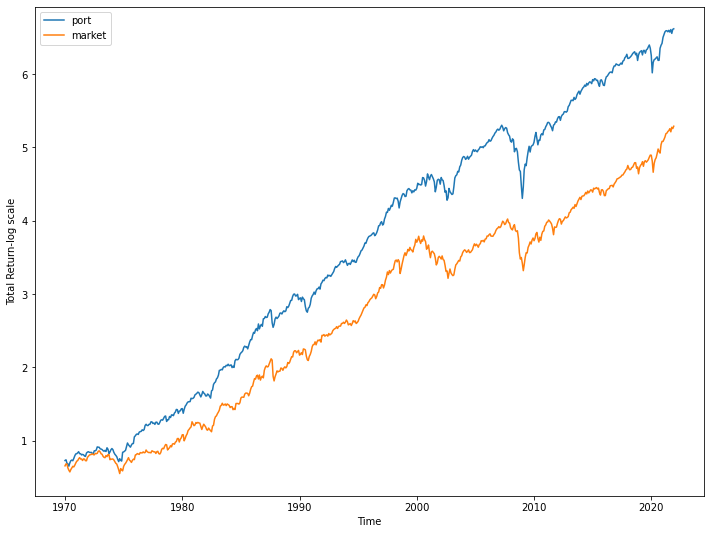

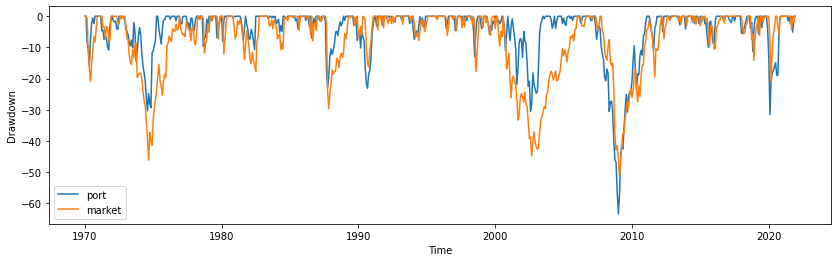

Total Compounded Annual Return(1970-2021)
Low Vol Port : 744.9470515782544
market : 196.62899497613483

Sharp
Portfolio : 6.012876852646637
market : 6.497807790725752

MDD
Portfolio : -63.43596824043786
market : -51.47866447611208

size long port result


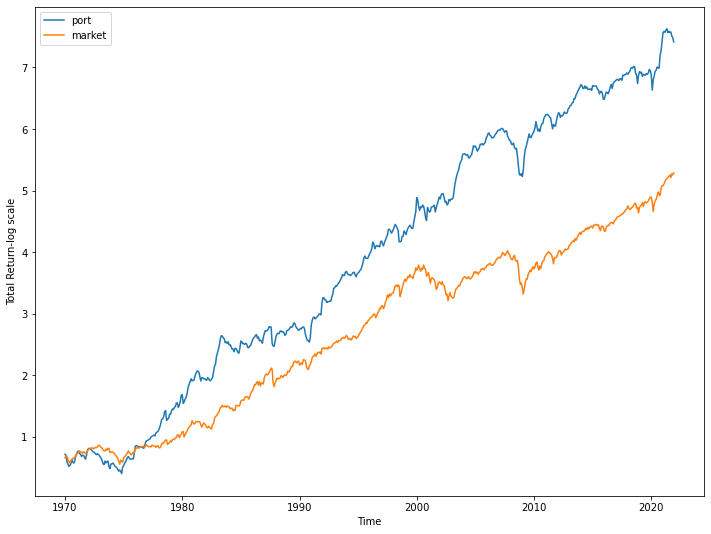

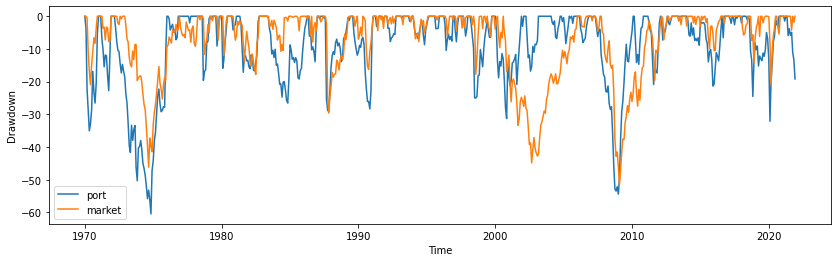

Total Compounded Annual Return(1970-2021)
Low Vol Port : 1661.011008868402
market : 196.62899497613483

Sharp
Portfolio : 4.01118148566264
market : 6.497807790725752

MDD
Portfolio : -60.45395432996875
market : -51.47866447611208


In [384]:
def visualize(port_result):
    fig = plt.figure(figsize=(12, 9))
    plt.plot(port_result['cumulative_return'].index.to_timestamp(), np.log(1+port_result['cumulative_return'].values), label='port')
    plt.plot(mkt_result['cumulative_return'].index.to_timestamp(), np.log(1+mkt_result['cumulative_return'].values), label='market')
    plt.xlabel('Time')
    plt.ylabel('Total Return-log scale')
    plt.legend()
    plt.show()
    fig = plt.figure(figsize=(14, 4))
    plt.plot(port_result['drawdown'].index.to_timestamp(), port_result['drawdown'].values, label='port')
    plt.plot( mkt_result['drawdown'].index.to_timestamp(), mkt_result['drawdown'].values, label='market')
    plt.xlabel('Time')
    plt.ylabel('Drawdown')
    plt.legend()
    plt.show()
    print("Total Compounded Annual Return(1970-2021)\nLow Vol Port :", port_result['total_return'])
    print("market :", mkt_result['total_return'])
    print("\nSharp\nPortfolio :", port_result['sharp'])
    print("market :", mkt_result['sharp'])
    print("\nMDD\nPortfolio :", port_result['mdd'])
    print("market :", mkt_result['mdd'])

print('value long port result')
visualize(value_result)
print('\nsize long port result')
visualize(size_result)

### **Problem 2. Long/Short Portfolio**

We aim to confirm that the returns of the Long/Short Portfolio are greater than or equal to zero.

1. Data Load - Same as the Long Portfolio.

2. Z-Scoring - Same as the Long Portfolio.

3. Score Aggregation - Same as the Long Portfolio.

4. Construct Long/Short Portfolio
    We construct the Long Portfolio by buying the bottom 30% of stocks (i.e., stocks with low volatility) based on the aggregated Z-Score. Simultaneously, we construct the Short Portfolio by short-selling the top 30% of stocks (i.e., stocks with high volatility). Both portfolios are constructed using market capitalization weighting.
    The entire portfolio is constructed in a market-neutral manner by weighting the long portfolio with $\frac{\beta_{short}}{\beta_{long}+\beta_{short}}$ and the short portfolio with $\frac{\beta_{long}}{\beta_{long}+\beta_{short}}$. Specifically,

5. Long Portfolio and Short Portfolio are constructed based on market capitalization.
    My Portfolio (long-short) = $\frac{\beta_{short}}{\beta_{long}+\beta_{short}}$ Long Portfolio - $\frac{\beta_{long}}{\beta_{long}+\beta_{short}}$ Short Portfolio.
    In this way, a market-neutral portfolio with a total exposure of 1 is constructed. Similar to the Long Portfolio, the portfolio is rebalanced at the end of the holding period of 18 months.

    Market-neutral portfolio: https://www.investopedia.com/terms/m/marketneutral.asp

    Additional explanation:
    The reason why this approach leads to a market-neutral portfolio is as follows:
    According to the Capital Asset Pricing Model (CAPM), the expected returns of the Long Portfolio and Short Portfolio are as follows:
    $$E(R_{long}^e)=\alpha_{long}+\beta_{long}E(R_m^e)$$
    $$E(R_{short}^e)=\alpha_{short}+\beta_{short}E(R_m^e)$$

    The expected return of My Portfolio (Long-Short Portfolio) is: $$\begin{aligned}E(R_{my}) &=E\left(\frac{\beta_{short}}{\beta_{long}+\beta_{short}} R_{long}^e-\frac{\beta_{long}}{\beta_{long}+\beta_{short}} R_{short}^e\right) \\ &=\frac{\beta_{short}}{\beta_{long}+\beta_{short}}E(R_{long}^e)-\frac{\beta_{long}}{\beta_{long}+\beta_{short}}E(R_{short}^e) \\ &=\frac{\beta_{short}}{\beta_{long}+\beta_{short}}(\alpha_{long}+\beta_{long}E(R_m^e))-\frac{\beta_{long}}{\beta_{long}+\beta_{short}}(\alpha_{short}+\beta_{short}E(R_m^e)) \\ &=\frac{(\beta_{short}\alpha_{long}-\beta_{short}\alpha_{short})}{\beta_{long}+\beta_{short}}+\frac{(\beta_{short}\beta_{long}-\beta_{long}\beta_{short})}{\beta_{long}+\beta_{short}}E(R_m^e) \\ &=\frac{(\beta_{short}\alpha_{long}-\beta_{short}\alpha_{short})}{\beta_{long}+\beta_{short}}=\alpha^* \end{aligned}$$
 (for some constant $\alpha^*$)

    Therefore, the effect of the market (i.e., $E(R_m^e)$) is removed, and the expected return of My Portfolio becomes a suitable constant $\alpha^*$, allowing for the construction of a market-neutral (market-independent) portfolio.

6. Statistical Robustness of Alpha
    By constructing the portfolio in the above manner, market fluctuations are removed from the portfolio's returns, leaving only alpha. T-tests can be performed to demonstrate that the alpha (the returns of the Long-Short Portfolio) is statistically robust and greater than or equal to 0.

7. Visualization
    The cumulative returns of the Long/Short Portfolio

In [385]:
#4 constructing long-short portfolio
def construct_mkt_neutral_port(long_quantile, short_quantile, equipty_info):    
    long_selected = equipty_info.groupby(level=0)['total_score'].apply(lambda x: x<x.quantile(long_quantile))
    short_selected = equipty_info.groupby(level=0)['total_score'].apply(lambda x: x>x.quantile(short_quantile))
    long_port = equipty_info[['cap']]
    short_port = equipty_info[['cap']]
    long_port.loc[~long_selected, 'cap'] = 0
    short_port.loc[~short_selected, 'cap'] = 0
    long_port['weight'] = long_port.groupby(level=0)[['cap']].apply(lambda x:x/x.sum())
    short_port['weight'] = short_port.groupby(level=0)[['cap']].apply(lambda x:x/x.sum())
    long_beta = equipty_info['beta'].multiply(long_port['weight'], axis='index').groupby('mdate').transform(lambda x:x.sum()).values
    short_beta = equipty_info['beta'].multiply(short_port['weight'], axis='index').groupby('mdate').transform(lambda x:x.sum()).values
    mkt_neutral_port = long_port['weight']*short_beta/(long_beta+short_beta) - short_port['weight']*long_beta/(long_beta+short_beta)
    return mkt_neutral_port
    
value_mkt_neutral_port = construct_mkt_neutral_port(0.3, 0.7, value.set_index(['mdate','cusip']))
size_mkt_neutral_port = construct_mkt_neutral_port(0.3, 0.7, size.set_index(['mdate','cusip']))
print('value mkt neutral portfolio')
print(value_mkt_neutral_port)
print('\nsize mkt neutral portfolio')
print(size_mkt_neutral_port)

<ipython-input-385-5e6d1f816cd7>:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  long_selected = equipty_info.groupby(level=0)['total_score'].apply(lambda x: x<x.quantile(long_quantile))
<ipython-input-385-5e6d1f816cd7>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  short_selected = equipty_i

value mkt neutral portfolio
mdate    cusip    
1970-01  000957100   -0.000093
         001007103   -0.000293
         001412105    0.000000
         001476100    0.000000
         001688100    0.001403
                        ...   
2021-12  98986M103   -0.000006
         98986T108    0.000951
         98986X109    0.000000
         G65163100    0.000000
         G8588X103    0.000000
Name: weight, Length: 2643451, dtype: float64

size mkt neutral portfolio
mdate    cusip    
1970-01  000957100    0.000000
         001007103   -0.000187
         001412105    0.000988
         001476100    0.000000
         001688100   -0.000475
                        ...   
2021-12  98986M103    0.000000
         98986T108   -0.000127
         98986X109    0.000395
         G65163100   -0.000031
         G8588X103         NaN
Name: weight, Length: 2643451, dtype: float64


                         weight
mdate   cusip                  
1970-01 000957100 -9.286711e-05
        001007103 -2.932227e-04
        001412105  0.000000e+00
        001476100  0.000000e+00
        001688100  1.402560e-03
...                         ...
2021-12 98986T108  9.107850e-04
        98986X109  0.000000e+00
        G2124G112  0.000000e+00
        G6S34K105 -7.790226e-07
        G8588X103           NaN

[2616504 rows x 1 columns]
                     weight
mdate   cusip              
1970-01 000957100  0.000000
        001007103 -0.000187
        001412105  0.000988
        001476100  0.000000
        001688100 -0.000475
...                     ...
2021-12 98986T108 -0.000195
        98986X109  0.000368
        G2124G112  0.000125
        G6S34K105  0.000089
        G8588X103       NaN

[2616504 rows x 1 columns]

value mkt neutral port returns
mdate
1970-01    0.021462
1970-02    0.021448
1970-03    0.006113
1970-04    0.026721
1970-05   -0.006551
             ...   
2021-0

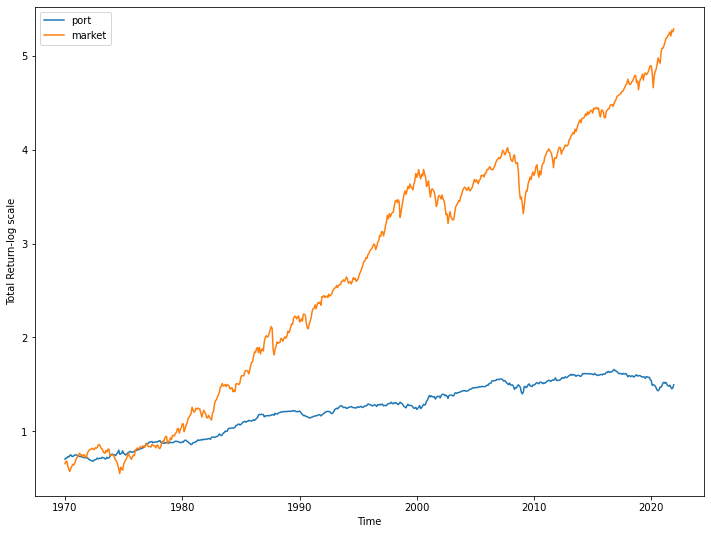

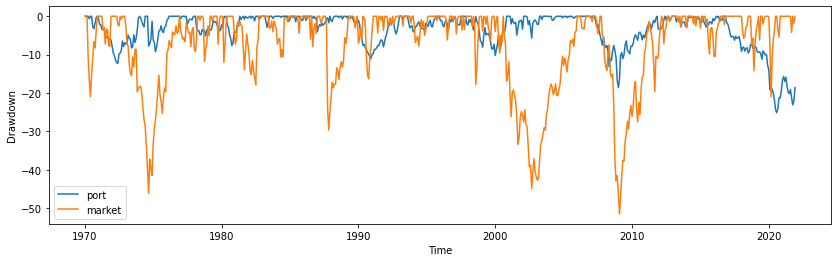

Total Compounded Annual Return(1970-2021)
Low Vol Port : 3.465993361456115
market : 196.62899497613483

Sharp
Portfolio : 17.667419657311306
market : 6.497807790725752

MDD
Portfolio : -25.11858875570063
market : -51.47866447611208

size mkt neutrlaized port result visualization


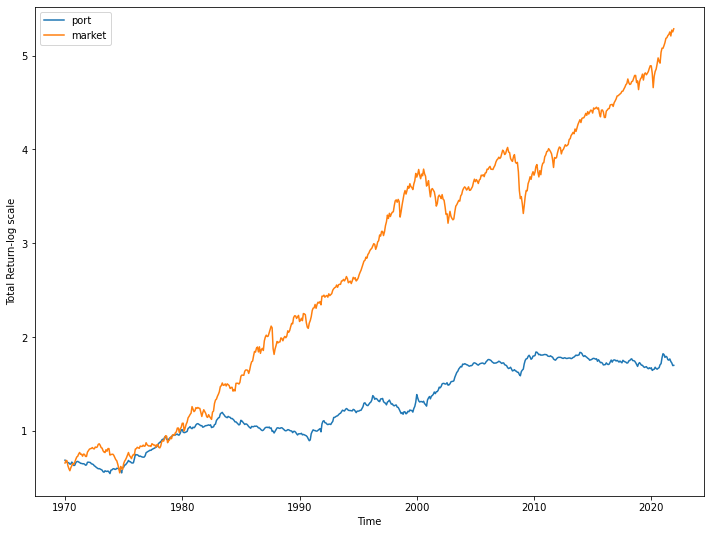

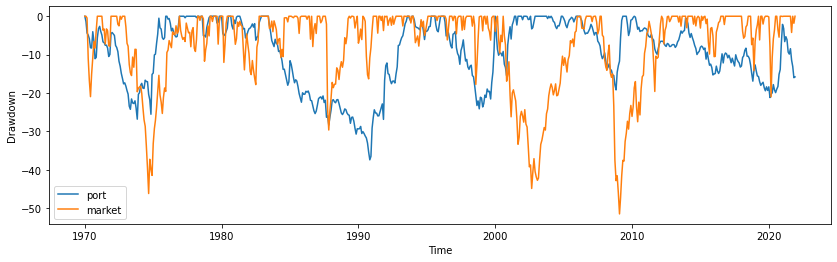

Total Compounded Annual Return(1970-2021)
Low Vol Port : 4.456028923808647
market : 196.62899497613483

Sharp
Portfolio : 9.789783704497584
market : 6.497807790725752

MDD
Portfolio : -37.39384876541795
market : -51.47866447611208

t-test for value mkt neutral port return > 0
Ttest_1sampResult(statistic=3.422120309460611, pvalue=0.0003310194357370415)

t-test for size mkt neutral port return > 0
Ttest_1sampResult(statistic=2.782602552610871, pvalue=0.0027779367585899608)


In [386]:
value_mkt_neutral_rebalanced_port = rebalance(value_mkt_neutral_port.reset_index(), 18)
size_mkt_neutral_rebalanced_port = rebalance(size_mkt_neutral_port.reset_index(), 18)
print(value_mkt_neutral_rebalanced_port)
print(size_mkt_neutral_rebalanced_port)

value_mkt_neutral_port_returns = get_portfolio_returns(value_mkt_neutral_rebalanced_port, value.set_index(['mdate','cusip'])[['return']])
size_mkt_neutral_port_returns = get_portfolio_returns(size_mkt_neutral_rebalanced_port, size.set_index(['mdate','cusip'])[['return']])
print('\nvalue mkt neutral port returns')
print(value_mkt_neutral_port_returns)
print('\nsize mkt neutral port returns')
print(size_mkt_neutral_port_returns)

value_mkt_neutral_port_result = analyze_result(value_mkt_neutral_port_returns)
size_mkt_neutral_result = analyze_result(size_mkt_neutral_port_returns)
print('\nvalue mkt netural port result')
print(value_mkt_neutral_port_result)
print('\nsize mkt netural port result')
print(size_mkt_neutral_result)

print('\nvalue mkt neutralized port result visualization')
visualize(value_mkt_neutral_port_result)
print('\nsize mkt neutrlaized port result visualization')
visualize(size_mkt_neutral_result)

print('\nt-test for value mkt neutral port return > 0')
print(stats.ttest_1samp(value_mkt_neutral_port_returns, popmean=0, alternative='greater'))
print('\nt-test for size mkt neutral port return > 0')
print(stats.ttest_1samp(size_mkt_neutral_port_returns, popmean=0, alternative='greater'))

### **Conclusion**
By observing the cumulative return graph of the value and size factor, we can actually see the effect of marktet neutralization and factor's own performance purely. We can also conclude the value and size factor has very steady return across time, resulting in a low correlation between the maximum drawdowns (MDD) of the portfolios and the market. Especially, remakrably low level of the mdd the value factor is showing is incredible. Note that the recent performance of the value factor can be considered the worst, with maximum drawdowns (MDDs) being the highest observed over the entire time period. The results of t-test allows us to reject the null hypothesis and say that each factors's return is positive at 1% confidence level. 

### **Problem 5. Size matters, if you control Junk**
https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2553889

After the 2000s, the size premium seems to have almost disappeared. According to Asness (2015), when the quality factor is added as an explanatory variable, the explanatory power of the size factor for cross-sectional stock variations increases. (The difference in returns between small and big size portfolios is significant for the same quality quartile. As shown in the table below, the excess returns increase as we move towards smaller size in all quality quartiles, and t-statistics are generally significant.) Using the given Size Score and Quality Score data, confirm that the size premium exists significantly when the quality is added as an explanatory variable.